# Code for CUQIpy paper 1, section 3

Sinc phantom example

In [1]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt

from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import Gaussian, Gamma, GMRF, LMRF, CMRF, JointDistribution
from cuqi.problem import BayesianProblem
from cuqi.sampler import CWMH, MALA, UGLA

print(f"cuqipy version: {cuqi.__version__}")

# Options
s = 0.01 # Noise standard deviation
seed = 4 # Random seed

cuqipy version: 0.8.0.post0.dev13


In [2]:
# For plotting
plt.rcParams.update({'font.size': 12})

## 3.1-3.3 Basics

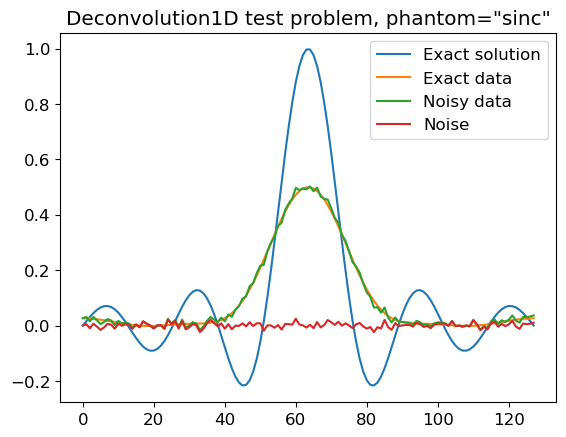

In [3]:
np.random.seed(seed)

A, y_data, info = Deconvolution1D(phantom='sinc', noise_std=s).get_components()

x_true = info.exactSolution
y_true = info.exactData

x_true.plot(label="Exact solution")
y_true.plot(label="Exact data")
y_data.plot(label="Noisy data")
(y_data-y_true).plot(label="Noise")

ax = plt.gca()
ylims = ax.get_ylim()
plt.title("Deconvolution1D test problem, phantom=\"sinc\"")
plt.legend()

In [4]:
# Demonstrate forward and adjoint
yx = A @ x_true
xx = A.T(yx)

In [5]:
# Exact parameters
m = A.range_dim
n = A.domain_dim
x_zero = np.zeros(n)

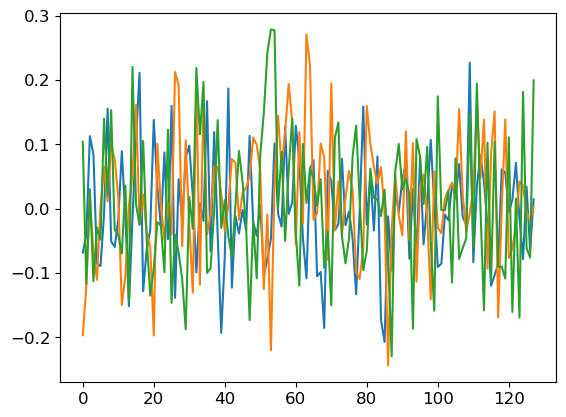

In [6]:
# Demonstrate the prior sampling 1
x = Gaussian(x_zero, 0.1**2)
samples_x = x.sample(3)
samples_x.plot()

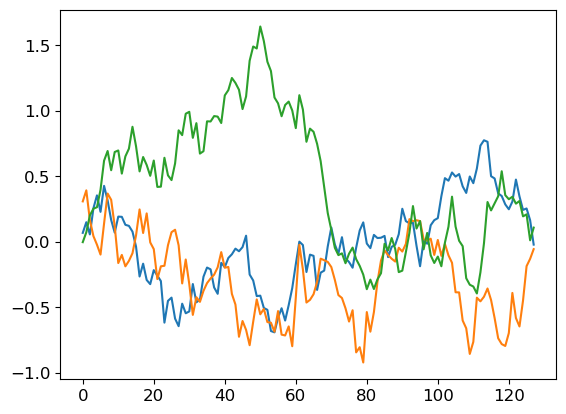

In [7]:
# Demonstrate the prior sampling 2
x = GMRF(x_zero, 50)
samples_x = x.sample(3)
samples_x.plot()

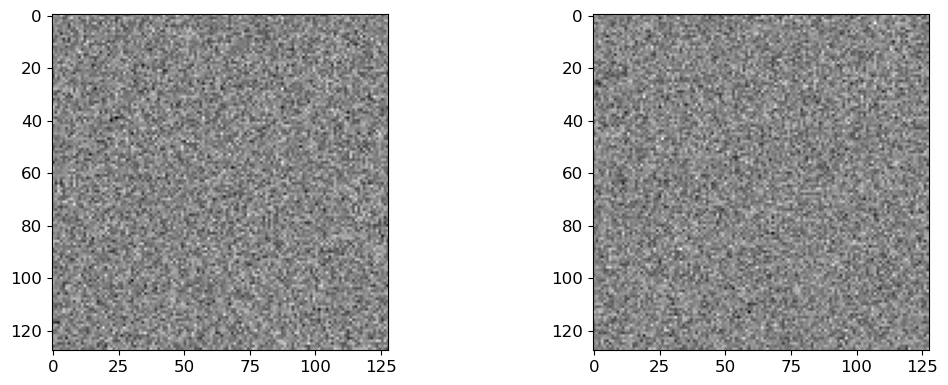

In [8]:
# Demonstrate the prior sampling 3
x = Gaussian(np.zeros(128**2), 0.1**2, geometry=cuqi.geometry.Image2D((128, 128)))
samples_x = x.sample(2)
samples_x.plot()

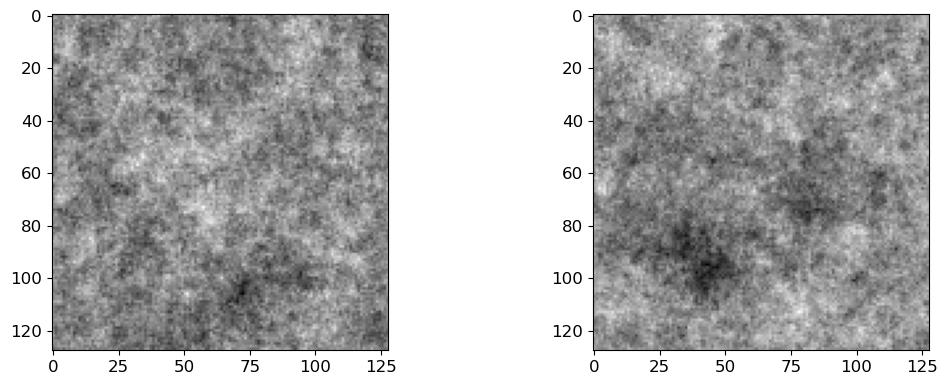

In [10]:
# Demonstrate the prior sampling 4
x = GMRF(np.zeros(128**2), 50, geometry=cuqi.geometry.Image2D((128, 128)))
samples_x = x.sample(2)
samples_x.plot()

## 3.4 Bayesian modelling 

In [13]:
# Simple Bayesian Problem
x = GMRF(x_zero, 50)  
y = Gaussian(A@x, s**2)

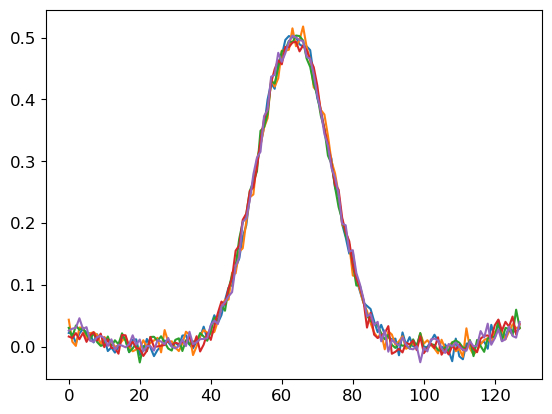

In [14]:
# Sample data distribution given true solution and plot
y(x=x_true).sample(5).plot()

In [15]:
# Set up the Bayesian problem
BP = BayesianProblem(y, x)
print(BP)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI GMRF.
)


In [16]:
# Set data
BP.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI GMRF.
 )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Likelihood
x0: ones vector
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


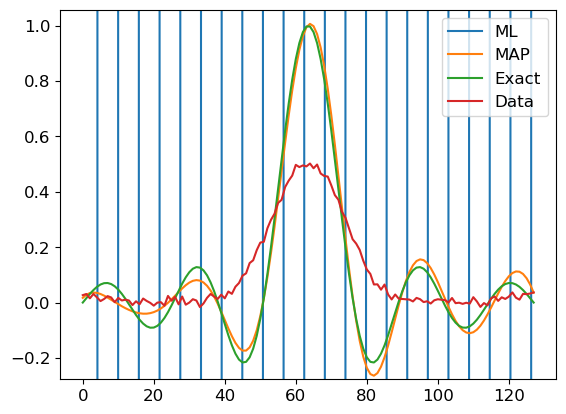

In [17]:
# Point estimates
x_ML = BP.ML()
x_MAP = BP.MAP()

x_ML.plot()
x_MAP.plot()
x_true.plot()
y_data.plot()
plt.ylim(ylims)
plt.legend(("ML", "MAP", "Exact", "Data"))

In [18]:
# Posterior sampling
samples = BP.sample_posterior(1000)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 3.7297768592834473


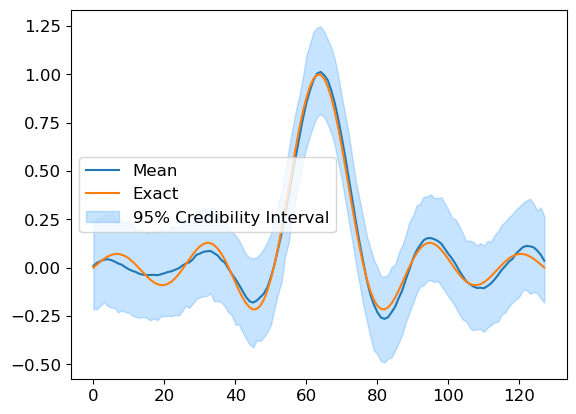

In [19]:
# Plot the samples
samples.plot_ci(exact=x_true)

## 3.5 Hierarchical modelling

Note the lambda functions will be unnecessary in next release of CUQIpy

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: LinearRTO
	s: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 5.7462780475616455
Plotting results


{'x': <cuqi.samples._samples.Samples at 0x7f9bbf713ee0>,
 's': <cuqi.samples._samples.Samples at 0x7f9bbf7129e0>}

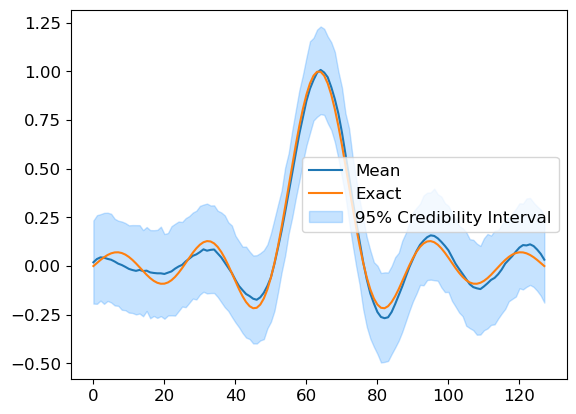

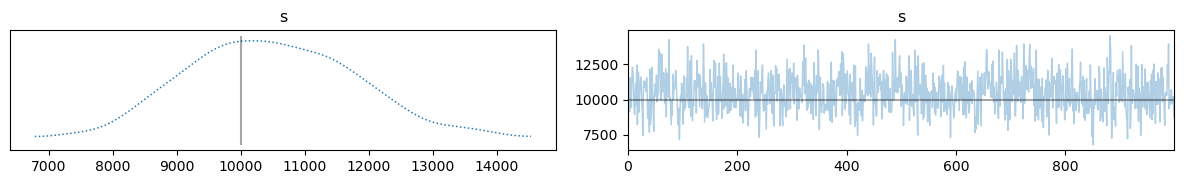

In [20]:
s = Gamma(1, 1e-4)
x = GMRF(x_zero, 50)
y = Gaussian(A@x, prec=lambda s: s)

BP = cuqi.problem.BayesianProblem(y, x, s)
BP.set_data(y=y_data)

BP.UQ(1000, exact={"x": x_true, "s": 1/0.01**2})